<a href="https://colab.research.google.com/github/Makhmoor-fiza/Colab-Notebooks/blob/main/Image_Classification_Using_Vision_Transformer_Nail_Melanoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set Up

In [1]:
# Install torchinfo
!pip install torchinfo


Mount Drive , if the data is placed on drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


set up the path for data and ensure unzipping


In [3]:
import os

# Define the dataset directory
dataset_dir = '/content/Datasets'

# Unzip the dataset only if it hasn't been unzipped yet
if not os.path.exists(dataset_dir):
    !unzip -o -q /content/drive/MyDrive/Datasets.zip -d /content/Datasets
    print("Dataset unzipped successfully.")
else:
    print("Dataset directory already exists. Skipping unzip.")


Dataset unzipped successfully.


Install necessary libraries

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from torchinfo import summary


Set Seed for Reproducibility

In [5]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds()


Define Helper Functions

In [6]:
def plot_loss_curves(results):
    epochs = range(1, len(results['train_loss']) + 1)
    plt.figure(figsize=(12,5))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, results['train_loss'], label='Train Loss')
    plt.plot(epochs, results['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, results['train_acc'], label='Train Accuracy')
    plt.plot(epochs, results['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.show()

def train(model, train_loader, test_loader, optimizer, loss_fn, epochs, device):
    results = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        results['train_loss'].append(epoch_loss)
        results['train_acc'].append(epoch_acc.item())

        # Evaluation phase
        model.eval()
        test_running_loss = 0.0
        test_running_corrects = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                _, preds = torch.max(outputs, 1)
                test_running_loss += loss.item() * inputs.size(0)
                test_running_corrects += torch.sum(preds == labels.data)
                test_total += labels.size(0)

        test_epoch_loss = test_running_loss / test_total
        test_epoch_acc = test_running_corrects.double() / test_total
        results['test_loss'].append(test_epoch_loss)
        results['test_acc'].append(test_epoch_acc.item())

        print(f"Epoch: {epoch} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Test Loss: {test_epoch_loss:.4f} | Test Acc: {test_epoch_acc:.4f}")

    return results

def pred_and_plot_image(model, image_path, class_names, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    img = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        pred_class = class_names[preds.item()]

    plt.imshow(image)
    plt.title(f"Predicted: {pred_class}")
    plt.axis('off')
    plt.show()


In [9]:
!ls /content/Datasets/


dataset


In [10]:
!ls /content/Datasets/dataset/


test  train


In [11]:
!ls /content/Datasets/dataset/train/


melanoma  normal


In [12]:
# Define paths with the correct directory structure
train_dir = '/content/Datasets/dataset/train'
test_dir = '/content/Datasets/dataset/test'


Prepare Data Loaders

In [13]:
# 6. Prepare Data Loaders

# Define paths
train_dir = '/content/Datasets/dataset/train'
test_dir = '/content/Datasets/dataset/test'

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Get pretrained ViT transforms
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT
pretrained_vit_transforms = pretrained_vit_weights.transforms()

# Create DataLoaders
def create_dataloaders(train_dir, test_dir, transform, batch_size=32, num_workers=2):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    class_names = train_data.classes

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, test_loader, class_names

train_loader, test_loader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32,
    num_workers=2
)

print(f"Classes: {class_names}")


Using device: cpu
Classes: ['melanoma', 'normal']


Load and Modify the Pretrained ViT Model

In [14]:
# Load pretrained ViT model
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze all parameters
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Replace the classifier head
num_features = pretrained_vit.heads.head.in_features
pretrained_vit.heads.head = nn.Linear(num_features, len(class_names)).to(device)

# Print model summary
summary(pretrained_vit, input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 138MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Train the Model

In [15]:
# Define optimizer and loss function
optimizer = optim.Adam(pretrained_vit.heads.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Train the model
epochs = 10
results = train(
    model=pretrained_vit,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device
)


Epoch: 1 | Train Loss: 0.7031 | Train Acc: 0.5878 | Test Loss: 0.5143 | Test Acc: 0.7241
Epoch: 2 | Train Loss: 0.4138 | Train Acc: 0.8473 | Test Loss: 0.3993 | Test Acc: 0.8621
Epoch: 3 | Train Loss: 0.2672 | Train Acc: 0.9771 | Test Loss: 0.3498 | Test Acc: 0.8621
Epoch: 4 | Train Loss: 0.1874 | Train Acc: 0.9847 | Test Loss: 0.3108 | Test Acc: 0.8621
Epoch: 5 | Train Loss: 0.1415 | Train Acc: 0.9847 | Test Loss: 0.2891 | Test Acc: 0.8621
Epoch: 6 | Train Loss: 0.1107 | Train Acc: 0.9847 | Test Loss: 0.2701 | Test Acc: 0.8621
Epoch: 7 | Train Loss: 0.0922 | Train Acc: 0.9924 | Test Loss: 0.2538 | Test Acc: 0.9138
Epoch: 8 | Train Loss: 0.0789 | Train Acc: 0.9924 | Test Loss: 0.2445 | Test Acc: 0.9138
Epoch: 9 | Train Loss: 0.0695 | Train Acc: 0.9924 | Test Loss: 0.2374 | Test Acc: 0.9138
Epoch: 10 | Train Loss: 0.0630 | Train Acc: 0.9924 | Test Loss: 0.2312 | Test Acc: 0.9138


Plot Loss Curves

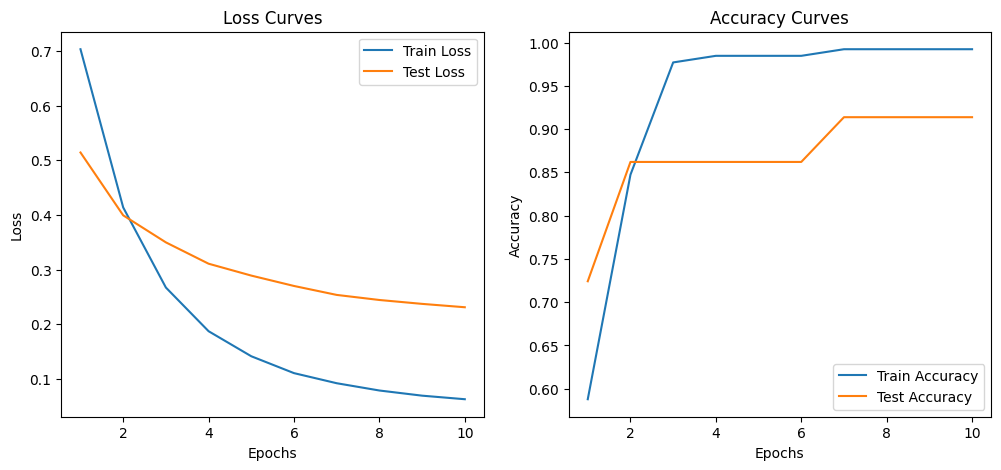

In [16]:
plot_loss_curves(results)


Make a prediction with custom Image

In [31]:
import torch
from torchvision import transforms
from PIL import Image
from google.colab import files

# Assuming you've already defined and loaded your model
pretrained_vit.eval()  # Set model to evaluation mode

# Define image transformations
pretrained_vit_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.CenterCrop(224),      # Crop to 224x224
    transforms.ToTensor(),            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Upload images
uploaded = files.upload()

# Print the uploaded filenames
print("Uploaded files:")
for filename in uploaded.keys():
    print(filename)

# Use the uploaded file(s) for prediction
for image_path in uploaded.keys():
    print(f"Processing {image_path}...")
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    image = pretrained_vit_transforms(image).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = pretrained_vit(image)  # Get model outputs
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    # Print the prediction
    print(f"Predicted class for {image_path}: {class_names[predicted.item()]}")


Saving test_image2.jpg to test_image2.jpg
Uploaded files:
test_image2.jpg
Processing test_image2.jpg...
Predicted class for test_image2.jpg: melanoma


Save the model

In [18]:
# Save the entire model
torch.save(pretrained_vit.state_dict(), 'pretrained_vit_model.pth')


Collecting the traininig results, insure it will run the code again. # Not Working, Needs troubleshooting

In [37]:
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn

# Assuming `pretrained_vit` is your model and `train_loader`, `test_loader` are your data loaders

# Define optimizer and loss function
optimizer = optim.Adam(pretrained_vit.heads.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Define the number of epochs for training
num_epochs = 10

# Initialize a dictionary to store training results
pretrained_vit_results = {
    'epoch': [],
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

# Training loop
for epoch in range(num_epochs):
    pretrained_vit.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    # Training step
    for images, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = pretrained_vit(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        train_loss += loss.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        train_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_train += labels.size(0)  # Total examples

    # Calculate training metrics
    train_loss /= total_train
    train_accuracy = train_correct / total_train

    # Validation step
    pretrained_vit.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            outputs = pretrained_vit(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation metrics
    val_loss /= total_val
    val_accuracy = val_correct / total_val

    # Save the results for this epoch
    pretrained_vit_results['epoch'].append(epoch + 1)  # Store epoch number (1-indexed)
    pretrained_vit_results['train_loss'].append(train_loss)
    pretrained_vit_results['train_accuracy'].append(train_accuracy)
    pretrained_vit_results['val_loss'].append(val_loss)
    pretrained_vit_results['val_accuracy'].append(val_accuracy)

    # Print results for the current epoch
    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test Loss: {val_loss:.4f} | Test Acc: {val_accuracy:.4f}")

# After training, convert to DataFrame and save
results_df = pd.DataFrame(pretrained_vit_results)
results_df.to_csv('training_results.csv', index=False)

print("Training results saved to 'training_results.csv'.")


AttributeError: 'EfficientNet' object has no attribute 'heads'

 Collecting Prediction Results

In [35]:
# Initialize a dictionary to store prediction results
pretrained_vit_prediction_results = {
    'image_path': [],
    'predicted_class': []
}

# Use the uploaded file(s) for prediction
for image_path in uploaded.keys():
    print(f"Processing {image_path}...")
    image = Image.open(image_path).convert("RGB")
    image = pretrained_vit_transforms(image).unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        outputs = pretrained_vit(image)
        _, predicted = torch.max(outputs, 1)

    # Save the prediction result
    pretrained_vit_prediction_results['image_path'].append(image_path)
    pretrained_vit_prediction_results['predicted_class'].append(class_names[predicted.item()])

# After prediction, convert to DataFrame and save
prediction_results_df = pd.DataFrame(pretrained_vit_prediction_results)
prediction_results_df.to_csv('prediction_results.csv', index=False)


Processing test_image2.jpg...


In [36]:
# Downloading files from google colab
from google.colab import files

files.download('pretrained_vit_model.pth')
files.download('training_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>